#  <center> Speech Emotion Recognition <center>

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [4]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [10]:
# Paths for data.
Ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "cremad/AudioWAV/"
Tess = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [8]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
1  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
2  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
3  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
4     calm  ravdess-emotional-speech-audio/audio_speech_ac...

## <center>2. Crema-D DataFrame</center>

In [11]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                 Path
0    angry  cremad/AudioWAV/1001_DFA_ANG_XX.wav
1  disgust  cremad/AudioWAV/1001_DFA_DIS_XX.wav
2     fear  cremad/AudioWAV/1001_DFA_FEA_XX.wav
3    happy  cremad/AudioWAV/1001_DFA_HAP_XX.wav
4  neutral  cremad/AudioWAV/1001_DFA_NEU_XX.wav

##  <center> 3. TESS dataset <center>

In [12]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  toronto-emotional-speech-set-tess/tess toronto...
1    angry  toronto-emotional-speech-set-tess/tess toronto...
2    angry  toronto-emotional-speech-set-tess/tess toronto...
3    angry  toronto-emotional-speech-set-tess/tess toronto...
4    angry  toronto-emotional-speech-set-tess/tess toronto...

##  <center> 4. SAVEE dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [13]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  surrey-audiovisual-expressed-emotion-savee/ALL...
1    angry  surrey-audiovisual-expressed-emotion-savee/ALL...
2    angry  surrey-audiovisual-expressed-emotion-savee/ALL...
3    angry  surrey-audiovisual-expressed-emotion-savee/ALL...
4    angry  surrey-audiovisual-expressed-emotion-savee/ALL...

In [14]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Tess_df, Crema_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
1  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
2  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
3  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
4     calm  ravdess-emotional-speech-audio/audio_speech_ac...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [18]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

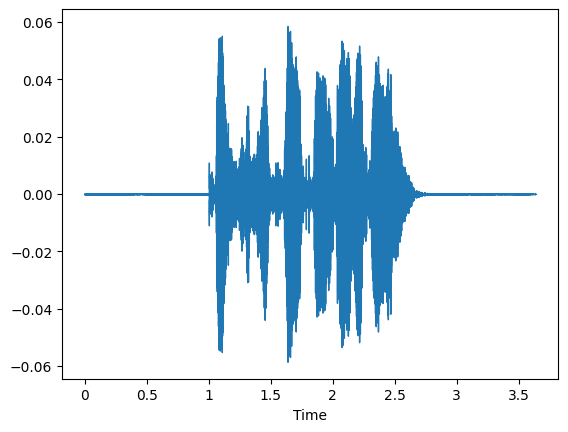

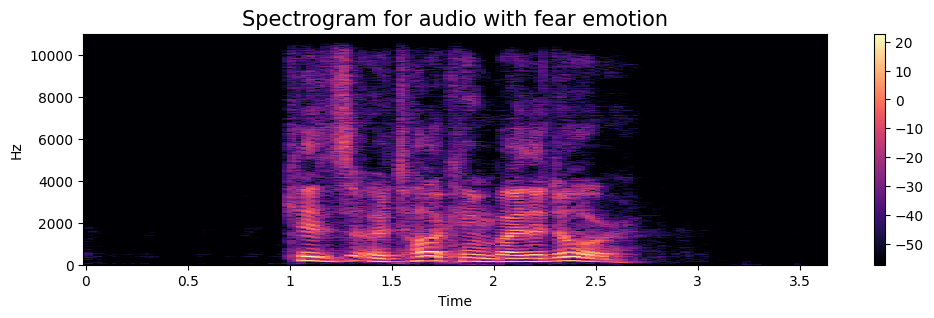

In [19]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data, sr=sampling_rate)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

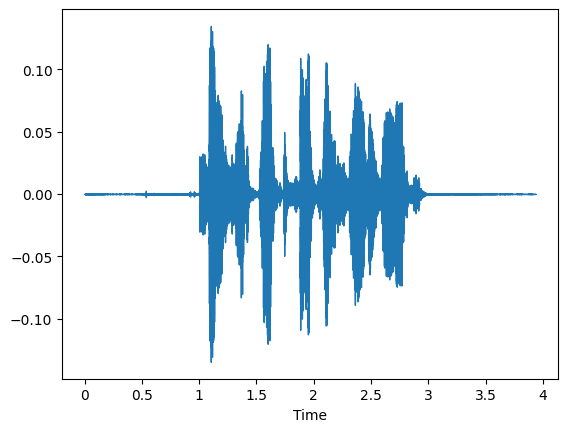

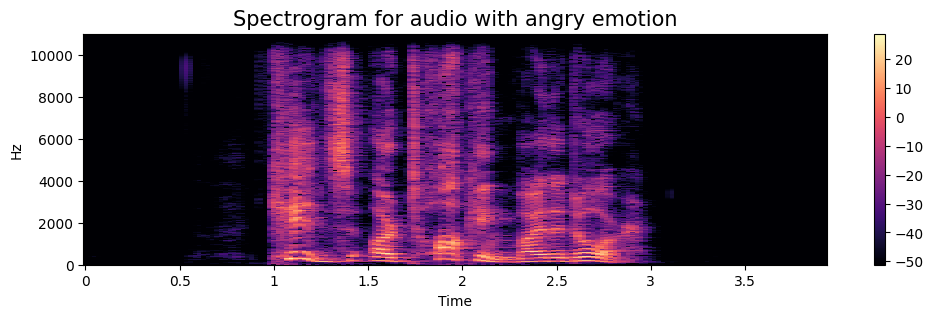

In [20]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data, sr=sampling_rate)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

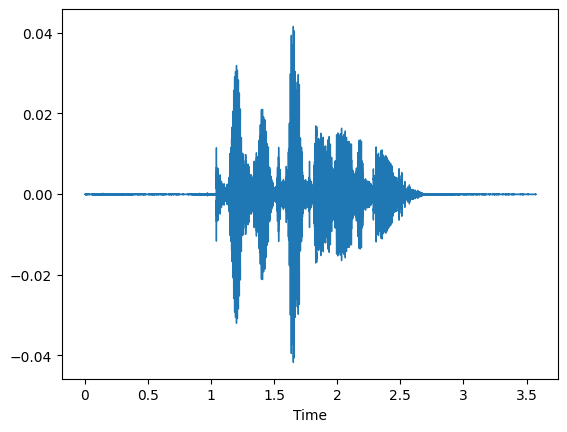

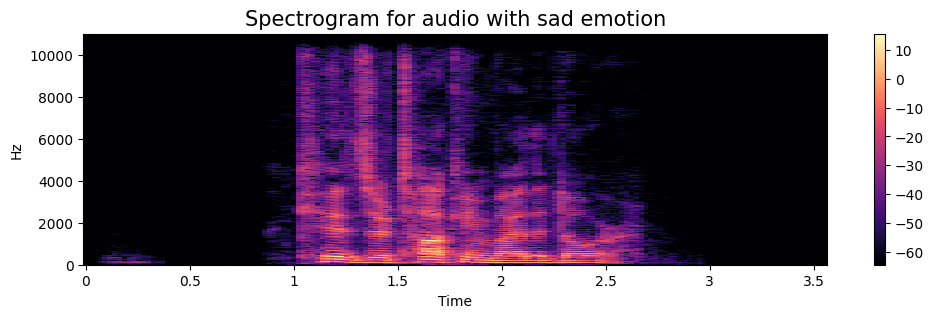

In [21]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data, sr=sampling_rate)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

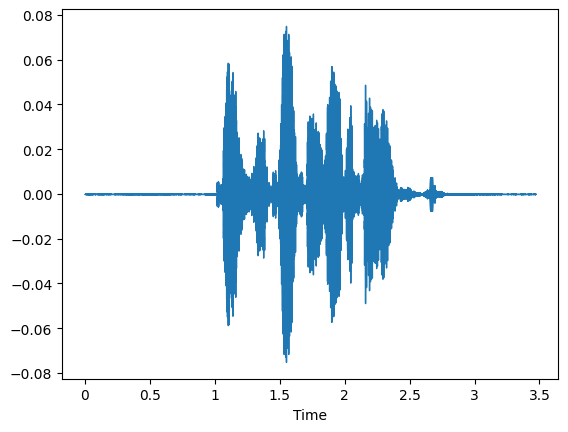

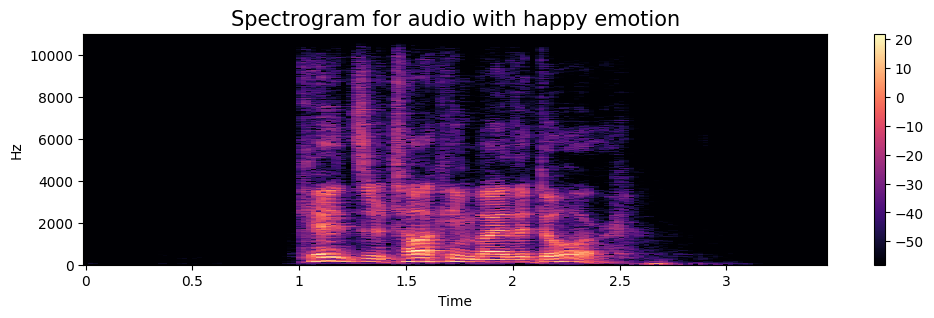

In [22]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data, sr=sampling_rate)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

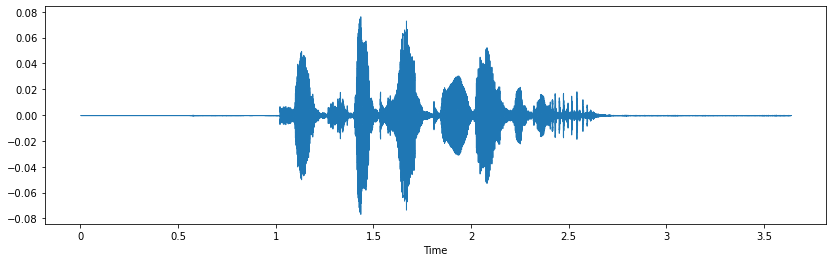

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

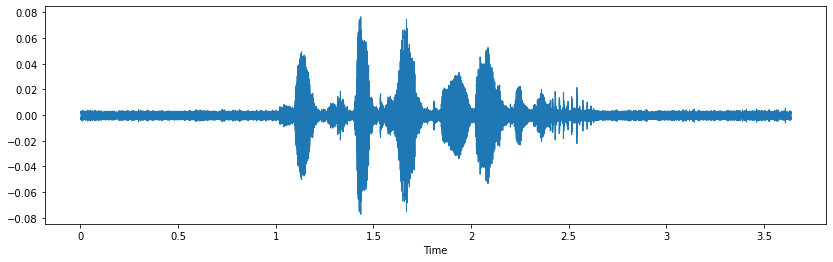

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

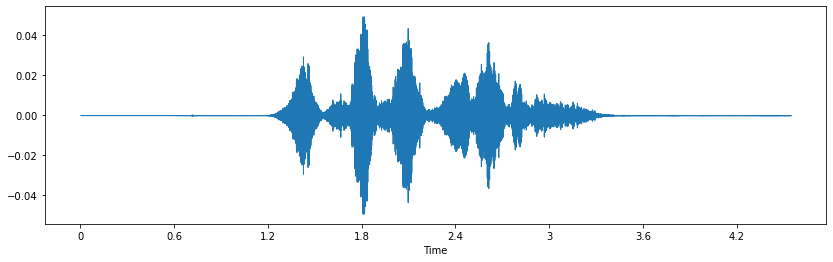

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

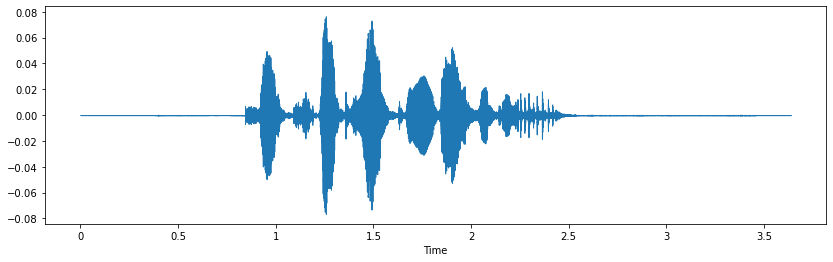

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

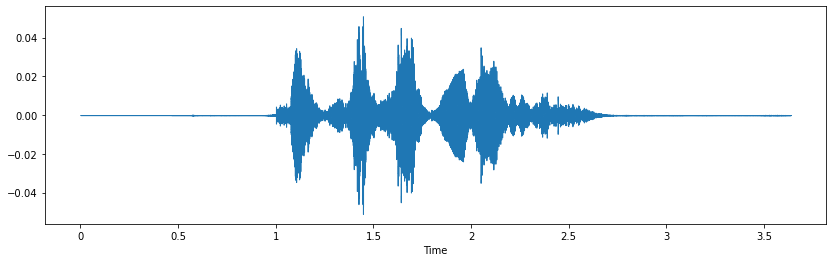

In [19]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

In this project features which are good for our dataset are these 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [20]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [21]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [22]:
len(X), len(Y), data_path.Path.shape+

(14160, 14160, (4720,))

In [23]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.236364  0.682306  0.670562  0.614833  0.576778  0.556679  0.635724   
1  0.326760  0.716770  0.734809  0.725692  0.705610  0.718520  0.744506   
2  0.184397  0.701746  0.670453  0.647094  0.564213  0.514649  0.620210   
3  0.249344  0.623034  0.581618  0.599602  0.623160  0.594028  0.598459   
4  0.285464  0.656860  0.649872  0.681091  0.726538  0.698426  0.652418   

          7         8         9  ...       153       154       155       156  \
0  0.667474  0.663903  0.669923  ...  0.000234  0.000236  0.000138  0.000129   
1  0.708012  0.689183  0.679431  ...  0.001006  0.001117  0.000980  0.000954   
2  0.694752  0.706844  0.679291  ...  0.000047  0.000049  0.000055  0.000048   
3  0.651520  0.699831  0.683130  ...  0.000018  0.000016  0.000013  0.000012   
4  0.663436  0.720180  0.711608  ...  0.000067  0.000064  0.000058  0.000058   

        157       158       159       160           161    labels  
0  0.000300  0.000354  0.000212  0.000081  1.317474e-05  surprise  
1  0.001120  0.001209  0.001031  0.000936  9.018224e-04  surprise  
2  0.000024  0.000052  0.000058  0.000014  8.380221e-07  surprise  
3  0.000007  0.000008  0.000007  0.000002  2.394528e-07   neutral  
4  0.000054  0.000056  0.000053  0.000050  4.771703e-05   neutral  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [24]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [25]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620, 8), (3540, 162), (3540, 8))

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620, 8), (3540, 162), (3540, 8))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162, 1), (10620, 8), (3540, 162, 1), (3540, 8))

## LSTM Modelling

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 128)          

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Train on 10620 samples, validate on 3540 samples
Epoch 1/50
10620/10620 [==============================] - 5s 485us/step - loss: 1.6980 - accuracy: 0.3540 - val_loss: 1.2449 - val_accuracy: 0.5633
Epoch 2/50
10620/10620 [==============================] - 2s 143us/step - loss: 1.2478 - accuracy: 0.5406 - val_loss: 1.0017 - val_accuracy: 0.6266
Epoch 3/50
10620/10620 [==============================] - 2s 155us/step - loss: 1.0754 - accuracy: 0.6020 - val_loss: 0.9089 - val_accuracy: 0.6636
Epoch 4/50
10620/10620 [==============================] - 2s 145us/step - loss: 0.9717 - accuracy: 0.6395 - val_loss: 0.8162 - val_accuracy: 0.6904
Epoch 5/50
10620/10620 [==============================] - 2s 144us/step - loss: 0.9156 - accuracy: 0.6650 - val_loss: 0.7580 - val_accuracy: 0.7153
Epoch 6/50
10620/10620 [==============================] - 2s 144us/step - loss: 0.8558 - accuracy: 0.6878 - val_loss: 0.7263 - val_accuracy: 0.7302
Epoch 7/50
10620/10620 [==============================] - 2s 14

3540/3540 [==============================] - 0s 94us/step
Accuracy of our model on test data :  87.51412630081177 %


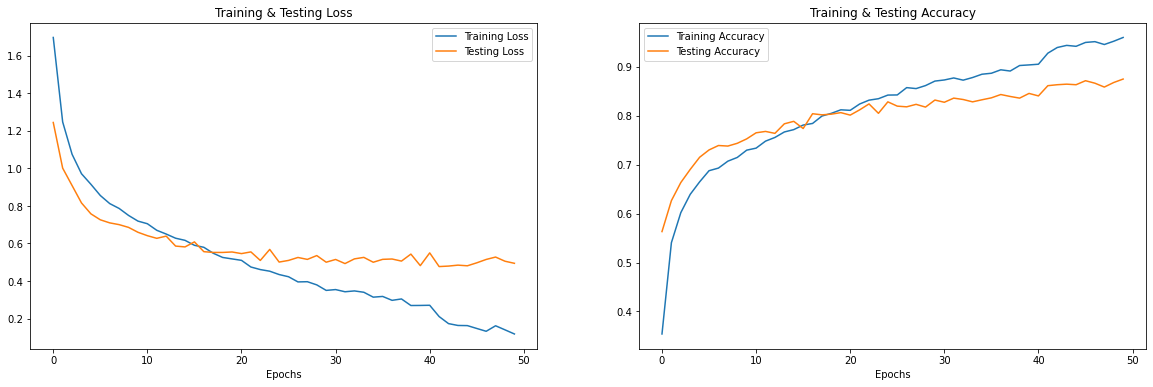

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

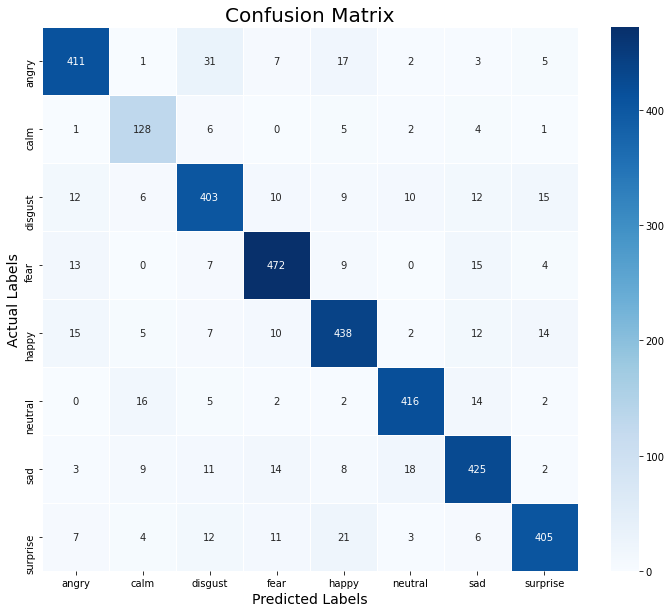

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.86      0.88       477
        calm       0.76      0.87      0.81       147
     disgust       0.84      0.84      0.84       477
        fear       0.90      0.91      0.90       520
       happy       0.86      0.87      0.87       503
     neutral       0.92      0.91      0.91       457
         sad       0.87      0.87      0.87       490
    surprise       0.90      0.86      0.88       469

    accuracy                           0.88      3540
   macro avg       0.87      0.87      0.87      3540
weighted avg       0.88      0.88      0.88      3540



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.